## Pipiline NLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/txt_sentoken.zip

--2024-05-22 08:05:05--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/txt_sentoken.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.150.86, 3.5.244.176, 3.5.244.113, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.150.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2781673 (2.7M) [application/octet-stream]
Saving to: ‘txt_sentoken.zip’

txt_sentoken.zip    100%[===================>]   2.65M  --.-KB/s    in 0.1s    

2024-05-22 08:05:05 (27.9 MB/s) - ‘txt_sentoken.zip’ saved [2781673/2781673]



In [3]:
!unzip txt_sentoken.zip

Archive:  txt_sentoken.zip
   creating: txt_sentoken/
   creating: txt_sentoken/neg/
  inflating: txt_sentoken/neg/cv000_29416.txt  
  inflating: txt_sentoken/neg/cv001_19502.txt  
  inflating: txt_sentoken/neg/cv002_17424.txt  
  inflating: txt_sentoken/neg/cv003_12683.txt  
  inflating: txt_sentoken/neg/cv004_12641.txt  
  inflating: txt_sentoken/neg/cv005_29357.txt  
  inflating: txt_sentoken/neg/cv006_17022.txt  
  inflating: txt_sentoken/neg/cv007_4992.txt  
  inflating: txt_sentoken/neg/cv008_29326.txt  
  inflating: txt_sentoken/neg/cv009_29417.txt  
  inflating: txt_sentoken/neg/cv010_29063.txt  
  inflating: txt_sentoken/neg/cv011_13044.txt  
  inflating: txt_sentoken/neg/cv012_29411.txt  
  inflating: txt_sentoken/neg/cv013_10494.txt  
  inflating: txt_sentoken/neg/cv014_15600.txt  
  inflating: txt_sentoken/neg/cv015_29356.txt  
  inflating: txt_sentoken/neg/cv016_4348.txt  
  inflating: txt_sentoken/neg/cv017_23487.txt  
  inflating: txt_sentoken/neg/cv018_21672.txt  
  inf

In [4]:
movie_data = load_files(r"txt_sentoken")
X_, y = movie_data.data, movie_data.target

In [5]:
df = pd.DataFrame({'text':X_})
df['label'] = y
df

,text,label
0,"b'lisa cholodenko\'s "" high art , "" is an inte...",1
1,"b'wolfgang petersen\'s latest , the perfect st...",0
2,b'i won\x12t even pretend that i have seen the...,0
3,b'there are some works of art that are almost ...,1
4,"b'albert brooks saves the day , just in the ni...",1
...,...,...
1408,"b'hav plenty , as we are told in the beginning...",0
1409,b'brian de palma\'s snake eyes stars nicolas c...,0
1410,b'contact ( pg ) there\'s a moment late in rob...,1
1411,"b""this is a film that i was inclined to like a...",0


In [6]:
## problemi di bytecode
def utfdecode(item):
    cleaned_item = item.decode('utf-8')
    return cleaned_item

df['text'] = df['text'].apply(utfdecode)
df

,text,label
0,"lisa cholodenko's "" high art , "" is an intelli...",1
1,"wolfgang petersen's latest , the perfect storm...",0
2,i wont even pretend that i have seen the othe...,0
3,there are some works of art that are almost im...,1
4,"albert brooks saves the day , just in the nick...",1
...,...,...
1408,"hav plenty , as we are told in the beginning a...",0
1409,brian de palma's snake eyes stars nicolas cage...,0
1410,contact ( pg ) there's a moment late in robert...,1
1411,this is a film that i was inclined to like at ...,0


In [7]:
## 1 Define Features and Target

X = df['text']
y = df['label']


In [8]:
import re

words_to_remove = ['gargamella', 'doggy', 'word3']
words_pattern = r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b'

patterns = {
            r"[a-zA-Z]+n\'t": 'not',
            r'\s+': ' ',             # Substitute multiple spaces with a single space
            r'\d+': '',              # Remove digits
            r'[^\w\s]': '',          # Remove punctuation and symbols
            r'\b\w{1,2}\b': '',      # Remove all tokens less than 2 characters
            r'(http|www)[^\s]+': '', # Remove websites
            words_pattern: ''        # Remove specific words
            }

def clean_column(df, column, patterns):
    df[column] = df[column].str.lower() # Apply lowercase transformation
    for pattern, replacement in patterns.items():
        df[column] = df[column].str.replace(pattern, replacement, regex=True)
    return df

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, patterns):
        self.patterns = patterns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=['text'])
        df = clean_column(df, 'text', self.patterns)
        return df['text'].values

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'attribute_ruler', 'ner'])

class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def lemmatize_text(self, text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.lemmatize_text(doc) for doc in X]

## PUT REGEX and lemmatizer inside Pipeline

In [11]:
text_cleaner = TextCleaner(patterns)
lemmatizer = SpacyLemmatizer()
bow = CountVectorizer(max_features=15000,stop_words="english") #stopwords removal
tfidf = TfidfTransformer()
clf = MultinomialNB(alpha=0.1)

pipe = Pipeline([
                ('TextCleaner', text_cleaner),   ## Regex and clean
                ('Lemmatizer', lemmatizer),      ## Lemmatizer SpaCy
                ('BoW', bow),                    ## BoW
                ('TF-IDF', tfidf),               ## TF-IDF
                ('Classifier', clf),             ## Classifier
                ])

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[0.76325088 0.79858657 0.77031802 0.77659574 0.75531915]
Mean cross-validation score:0.77
Standard deviation of cross-validation scores:0.01


In [13]:
pipe.fit(X, y)

Pipeline(steps=[('text cleaner',
                 TextCleaner(patterns={'(http|www)[^\\s]+': '', '[^\\w\\s]': '',
                                       "[a-zA-Z]+n\\'t": 'not',
                                       '\\b(?:gargamella|doggy|word3)\\b': '',
                                       '\\b\\w{1,2}\\b': '', '\\d+': '',
                                       '\\s+': ' '})),
                ('Lemmatizer', SpacyLemmatizer()),
                ('bow',
                 CountVectorizer(max_features=15000, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=0.1))])

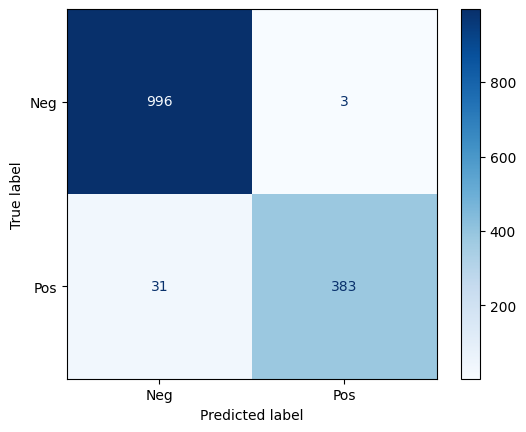

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['Neg','Pos']
ConfusionMatrixDisplay.from_estimator(pipe,
                                        X,
                                        y,
                                        cmap='Blues',
                                        display_labels=labels,
                                        );

In [15]:
y_pred_tot = pipe.predict(X)

In [16]:
from sklearn.metrics import classification_report

labels = ['Neg','Pos']
classification_report(y,y_pred_tot )
classification_report_result = classification_report(y, y_pred_tot,target_names=labels)
print(classification_report_result)

              precision    recall  f1-score   support

         Neg       0.97      1.00      0.98       999
         Pos       0.99      0.93      0.96       414

    accuracy                           0.98      1413
   macro avg       0.98      0.96      0.97      1413
weighted avg       0.98      0.98      0.98      1413



In [30]:
test_pos = """lisa cholodenko's " high art , " is an intelligent , quiet drama . its strongest quality , aside from the top-notch central performances , is the perceptive way in which the film , also written by cholodenko , observes its characters . they are all flawed people , some more troubled than others , but they are not judged . judging the characters in this picture would be a creative misstep on the filmmakers' parts , because no one , no matter how bad off they are , deserve to be negatively judged if they are involved in some serious problems that they cannot break free of . syd ( radha mitchell ) , a 24-year-old woman living with her longtime boyfriend james ( gabriel mann ) , has recently been awarded an ideal job at the high-profile photography magazine , " frame . " she very much enjoys where her career is headed , but is often not taken very seriously by her managers , who are always giving her petty jobs to do , when she knows she could be doing more important things . one night , while taking a bath , syd notices a leak coming from the apartment above hers , so when she goes up there to inform them of it , she meets lucy beliner ( ally sheedy ) , a thin , worn-out , and unhappy woman , who lives with her drug-addicted german girlfriend , greta ( patricia clarkson ) , a pathetic former actress who is usually so out-of-it that she often is in and out of conciousness . syd quickly strikes up a conversation with lucy , and discovers that she used to be an acclaimed photographer ten years before . lucy claims she doesn't want to get back into the profession , but syd manages to convince the " frame " editors to do a piece on her work . all the while , syd begins to grow deep feelings for lucy , even though she has never previously been attracted to a woman , and lucy starts a battle with her personal demons . " high art , " is such an effective motion picture because it is never suger-coated or idealized , but instead an honest and convincing portrait of a handful of unhappy people whose lives are going nowhere , while syd's luck begins to rise . the film in no way is about lesbianism , but about love , which was a refreshing change of pace from the usual stereotypical portraits of homosexuality . as lucy and syd grow closer and closer together , we really do believe that they are falling in love with each other , even if the relationship might be doomed . with this picture , ally sheedy's star has risen once again , thanks to her touching , nearly flawless portrtayal of lucy , a woman who , in the course of a decade , has found her life consumed almost entirely by drugs , which has taken away her once-blossoming career . her characted really is tragic , and one particular scene involving lucy and her mother , in which lucy admits to her that she has a drug problem , and her mother matter-of-factly responds by saying she can't help her , is heartbreaking . although not autobiographical , sheedy has had drug problems in her past , and i suspect she brought that knowledge of already being in lucy's footsteps to her role . also very good is radha mitchell as syd , who previously starred in the slight 1997 australian comedy , " love and other catastrophes , " wh caught me by surprise with her performance . easily being able to pass as christina ricci's older sister , mitchell obtains the same natural charisma that has made ricci so popular recently . as accurate as almost every detail is in , " high art , " i wish the relationship had been more tightly written involving syd and james , who , played by gabriel mann , is left with a throwaway role . by the time he finds out about syd and lucy , he disappears from the film , and i wish there had been another scene where they confronted each other . this is a very minor fault , however , in a film that is full of riches . although many of the characters are stuck in a hopeless pit of despair , syd and lucy are intelligent people who recognize their problems . the character of dominique ( anh duong ) , the " frame " editor who decides to give syd a chance with her ideas , was also written to be far more mature than expected . and the one sex scene in the film was beautifully and originally done . for once , it did not invlove steaminess , or violent sexual activity , or gratuitous nudity , but focused on the actual characters , who love each other , and their insecurities involved in making the decision to actually have sex . """
test_neg = """ the movie was so bad """


In [31]:
aa = pd.DataFrame({'text':[test_pos,test_neg]})

pipe.predict(aa)

array([1, 0])

In [32]:
import joblib

joblib.dump(pipe,'sent_pipe.pkl')

['sent_pipe.pkl']

In [33]:
model_pipe = joblib.load('sent_pipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [34]:
model_pipe

Pipeline(steps=[('text cleaner',
                 TextCleaner(patterns={'(http|www)[^\\s]+': '', '[^\\w\\s]': '',
                                       "[a-zA-Z]+n\\'t": 'not',
                                       '\\b(?:gargamella|doggy|word3)\\b': '',
                                       '\\b\\w{1,2}\\b': '', '\\d+': '',
                                       '\\s+': ' '})),
                ('Lemmatizer', SpacyLemmatizer()),
                ('bow',
                 CountVectorizer(max_features=15000, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=0.1))])